In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load the currency exchange rate dataset
exchange_rate_dataset = pd.read_excel('FX_FanU.xlsx', skiprows=3)
interested_currencies = ['Name', 'CANADIAN', 'EURO', 'UK', 'YEN', 'KRONA', 'SINGAPORE']

# Filter columns based on whether the header contains a G10 country
filtered_columns = [col for col in exchange_rate_dataset.columns if any(country in col for country in interested_currencies)]

# Select only the filtered columns in the DataFrame
fx_filtered = exchange_rate_dataset[filtered_columns]
fx_filtered = fx_filtered.drop([0, 1]).reset_index(drop = True)
fx_filtered.rename(columns={'Name': 'Date'}, inplace=True)

# Retain only Date
fx_filtered['Date'] = fx_filtered['Date'].astype(str)
fx_filtered['Date'] = fx_filtered['Date'].str.split(' ').str[0]

# Save filtered csv
fx_filtered.reset_index(drop = True)
fx_filtered.to_csv("fx_filtered.csv", index=False)

fx_filtered_train = fx_filtered[(fx_filtered['Date'] >= '2017-12-25') & (fx_filtered['Date'] <= '2018-12-31')]
fx_filtered_test = fx_filtered[(fx_filtered['Date'] >= '2019-12-25')]

In [3]:
currency = {"CA": "CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE",
            "FR": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "DE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "IT": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "NL": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "BE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "UK": "US $ TO UK £ 1M FWD (WMR) - EXCHANGE RATE",
            "JP": "JAPANESE YEN TO US $ 1M FWD (WMR) - EXCHANGE RATE",
            "SE": "SWEDISH KRONA TO US $ 1M FWD (WMR) - EXCHANGE RATE",
            "SG": "SINGAPORE $ TO US $ 1M FWD (WMR) - EXCHANGE RATE"}

In [4]:
# Extract and store the 'Date' column
dates = fx_filtered_train['Date']
test_dates = fx_filtered_test['Date']

# Iterate through the columns and create individual DataFrames
individual_dict, test_dict = {},{}
for column in fx_filtered_train.iloc[:, 1:]:
    individual_dict[column] = pd.DataFrame({column: fx_filtered_train[column]})

for column in fx_filtered_test.iloc[:, 1:]:
    test_dict[column] = pd.DataFrame({column: fx_filtered_test[column]})

In [5]:
# Define a custom dataset and dataloader
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (
            self.data[idx:idx+self.seq_length],
            self.data[idx+self.seq_length]
        )

In [6]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Run below to change currency

In [7]:
# Normalize the data
scaler = MinMaxScaler()

selection=""
while selection not in currency.keys():
    selection = input("Select currency from [CA, FR, DE, IT, NL, BE, UK, JP, SE, SG]: ").upper()

country = currency[selection]
country_df = individual_dict[country]
country_df = country_df.set_index(dates)
country_test_df = test_dict[country]
country_test_df = country_test_df.set_index(test_dates)

country_df_scaled = scaler.fit_transform(country_df)
country_test_df_scaled = scaler.fit_transform(country_test_df)

# Convert the data to PyTorch tensors
tensor_data = torch.FloatTensor(country_df_scaled)
tensor_test_data = torch.FloatTensor(country_test_df_scaled)

Select currency from [CA, FR, DE, IT, NL, BE, UK, JP, SE, SG]: ca


In [8]:

# Create dataset and dataloader
seq_length = 5
dataset = TimeSeriesDataset(tensor_data, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

test_dataset = TimeSeriesDataset(tensor_test_data, seq_length)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Instantiate the model, define loss function and optimizer
input_size = seq_length
hidden_size = 50
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training the model
num_epochs = 35
for epoch in range(num_epochs):
    for inputs, target in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/35], Loss: 0.7603
Epoch [2/35], Loss: 0.5360
Epoch [3/35], Loss: 0.3245
Epoch [4/35], Loss: 0.1499
Epoch [5/35], Loss: 0.0741
Epoch [6/35], Loss: 0.0792
Epoch [7/35], Loss: 0.1028
Epoch [8/35], Loss: 0.1081
Epoch [9/35], Loss: 0.0964
Epoch [10/35], Loss: 0.0822
Epoch [11/35], Loss: 0.0734
Epoch [12/35], Loss: 0.0685
Epoch [13/35], Loss: 0.0632
Epoch [14/35], Loss: 0.0560
Epoch [15/35], Loss: 0.0479
Epoch [16/35], Loss: 0.0404
Epoch [17/35], Loss: 0.0332
Epoch [18/35], Loss: 0.0261
Epoch [19/35], Loss: 0.0192
Epoch [20/35], Loss: 0.0130
Epoch [21/35], Loss: 0.0080
Epoch [22/35], Loss: 0.0042
Epoch [23/35], Loss: 0.0019
Epoch [24/35], Loss: 0.0008
Epoch [25/35], Loss: 0.0006
Epoch [26/35], Loss: 0.0007
Epoch [27/35], Loss: 0.0007
Epoch [28/35], Loss: 0.0007
Epoch [29/35], Loss: 0.0007
Epoch [30/35], Loss: 0.0007
Epoch [31/35], Loss: 0.0006
Epoch [32/35], Loss: 0.0006
Epoch [33/35], Loss: 0.0006
Epoch [34/35], Loss: 0.0006
Epoch [35/35], Loss: 0.0006


In [11]:
torch.save(model.state_dict(), fr'Currency\{selection}_model.pth')
print("Model saved!")

Model saved!


In [12]:
model.load_state_dict(torch.load(fr'Currency\{selection}_model.pth'))

# Evaluation
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
mae = 0.0
rmse = 0.0
with torch.no_grad():  # Disable gradient calculation during evaluation
    # Initialize a list to store values
    inputs_list, pred_actual_list = [], []

    # Iterate through the dataset for evaluation
    for inputs, target in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, target)

        # Accumulate the test loss
        test_loss += loss.item()

        # Calculate mean absolute error
        mae += mean_absolute_error(target.numpy(), outputs.numpy())

        # Calculate root mean square error
        rmse += np.sqrt(mean_squared_error(target.numpy(), outputs.numpy()))

        # Inverse transform the scaled prediction
        pred_actual = scaler.inverse_transform(np.concatenate((inputs.squeeze().numpy(), outputs.squeeze().numpy().reshape(-1, 1)), axis=1))[:, -1]

        # Append the predicted values to the list
        pred_actual_list.append(pred_actual)

# Calculate the average test loss
avg_test_loss = test_loss / len(test_dataloader)
avg_mae = mae/len(test_dataloader)
avg_rmse = rmse/len(test_dataloader)

# Print the average test loss
print(f'Average Test Loss: {avg_test_loss:.4f}')
print(f'Average MAE: {avg_mae:.4f}')
print(f'Average RMSE: {avg_rmse:.4f}')

# Flatten the list of predictions
pred_actual = np.concatenate(pred_actual_list)

Average Test Loss: 0.0023
Average MAE: 0.0368
Average RMSE: 0.0438


In [13]:
feature_min = country_df.iloc[:,-1].min()
feature_max = country_df.iloc[:,-1].max()
feature_range = feature_max-feature_min

print(feature_range)

0.13822999999999985


In [14]:
pred_df = pd.DataFrame(list(zip(test_dates.iloc[5:],pred_actual)))
pred_df.to_excel( "Currency\\" + selection + "_pred.xlsx")

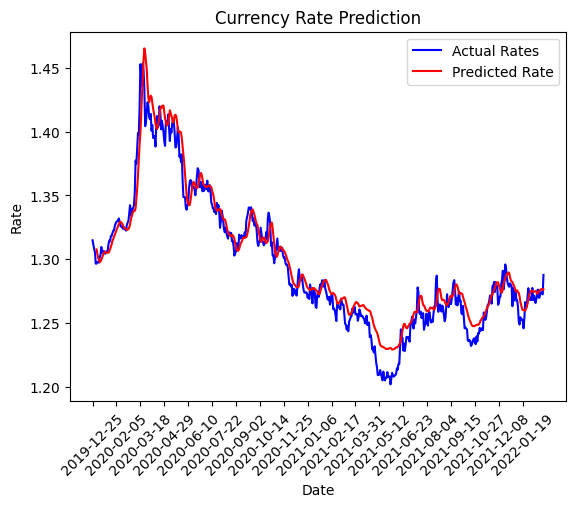

In [15]:
plt.plot(test_dates, country_test_df[country], label='Actual Rates', color='blue')
plt.plot(test_dates.iloc[5:],  pred_actual, markersize=8, label='Predicted Rate', color='red')
plt.title('Currency Rate Prediction')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
interval = 30
# interval = 10
plt.xticks(test_dates.iloc[::interval], rotation=45)
# plt.xlim(test_dates.iloc[0], test_dates.iloc[100])
plt.show()

## Work on Oxford Dataset

In [16]:
# Load the OxCGRT dataset
dtypes = {'RegionName': str, 'RegionCode': str}
oxcg_dataset = pd.read_csv('OxCGRT_compact_national_v1.csv', dtype=dtypes)
interested_countries = ['Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Belgium', 'United Kingdom', 'Japan', 'Sweden', 'Singapore']

# Filter the dataset to include only the G10 countries and Singapore
oxcg_filtered = oxcg_dataset[oxcg_dataset['CountryName'].isin(interested_countries)]

# Change formatting of date
def convert_date(date):
    original_date = datetime.strptime(str(date), '%Y%m%d')
    formatted_date_str = original_date.strftime('%Y-%m-%d')
    return formatted_date_str

oxcg_filtered['Date'] = oxcg_filtered['Date'].apply(convert_date)

# List of columns to drop
columns_to_drop = ["V1_Vaccine Prioritisation (summary)","V2A_Vaccine Availability (summary)","V2B_Vaccine age eligibility/availability age floor (general population summary)",
                   "V2C_Vaccine age eligibility/availability age floor (at risk summary)","V2D_Medically/ clinically vulnerable (Non-elderly)","V2E_Education",
                   "V2F_Frontline workers  (non healthcare)","V2G_Frontline workers  (healthcare)","V3_Vaccine Financial Support (summary)",
                   "V4_Mandatory Vaccination (summary)","ConfirmedDeaths","MajorityVaccinated","PopulationVaccinated",
                   "StringencyIndex_Average","GovernmentResponseIndex_Average","ContainmentHealthIndex_Average","EconomicSupportIndex",
                   "E1_Flag","H1_Flag","H7_Flag","C1M_Flag","C2M_Flag","C3M_Flag","C4M_Flag","C5M_Flag","C6M_Flag","C7M_Flag","H6M_Flag","H8M_Flag"]

# Drop unwanted columns
oxcg_filtered = oxcg_filtered.drop(columns=columns_to_drop)

oxcg_filtered = oxcg_filtered[(oxcg_filtered['Date'] <= '2022-02-24')]

grouped = oxcg_filtered.groupby('CountryName')

# Fill missing values within each group
oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))

# Reset the index to get a flat DataFrame
oxcg_filtered = oxcg_filtered.reset_index(drop=True)

for group_name, group_data in grouped:
    country = f"Countries data\\{group_name}_policy.csv"
    group_data.to_csv(country)

# Save filtered csv
oxcg_filtered.to_csv("OxCGRT_compact_national_v1_filtered.csv")

<ipython-input-16-e34952a2cfdc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxcg_filtered['Date'] = oxcg_filtered['Date'].apply(convert_date)
<ipython-input-16-e34952a2cfdc>:33: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))


In [17]:
country = {"CA": ["Canada", "CAD"],
            "FR": ["France", "EUR"],
            "DE": ["Germany", "EUR"],
            "IT": ["Italy", "EUR"],
            "NL": ["Netherlands", "EUR"],
            "BE": ["Belgium", "EUR"],
            "UK": ["United Kingdom", "GBP"],
            "JP": ["Japan", "YEN"],
            "SE": ["Sweden", "KR"],
            "SG": ["Singapore", "SGD"]}

In [18]:
oxcg_filtered = oxcg_filtered[oxcg_filtered["CountryName"] == country[selection][0]]

oxcg_filtered['DailyChange'] = oxcg_filtered["ConfirmedCases"].diff()
oxcg_filtered['DailyChange'] = oxcg_filtered['DailyChange'].fillna(0)

oxcg_filtered.drop(columns = "ConfirmedCases", inplace = True)

oxcg_filtered_train = oxcg_filtered[(oxcg_filtered['Date'] < '2021-01-01')]
oxcg_filtered_train = oxcg_filtered_train.reset_index(drop = True)

oxcg_filtered_test = oxcg_filtered[(oxcg_filtered['Date'] >= '2021-01-01')]
oxcg_filtered_test = oxcg_filtered_test.reset_index(drop = True)

<ipython-input-18-ed3585651db5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxcg_filtered['DailyChange'] = oxcg_filtered["ConfirmedCases"].diff()
<ipython-input-18-ed3585651db5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxcg_filtered['DailyChange'] = oxcg_filtered['DailyChange'].fillna(0)
<ipython-input-18-ed3585651db5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [19]:
# Select relevant features (COVID-19 policy data) and the target variable (exchange rate)
features = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events', 'C4M_Restrictions on gatherings', \
            'C5M_Close public transport', 'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement', \
            'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', \
            'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy', \
            'H8M_Protection of elderly people', 'DailyChange']

#### Function to fetch the currenctly selected currency's column name from filtered_fx

In [20]:
def get_fx_rate_column_name(selection, currency_dict):
    if selection in currency_dict:
        return currency_dict[selection]
    else:
        raise ValueError(f"Selection {selection} is not in the currency dictionary.")

currency = {"CA": "CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE",
            "FR": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "DE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "IT": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "NL": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "BE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE",
            "UK": "US $ TO UK £ 1M FWD (WMR) - EXCHANGE RATE",
            "JP": "JAPANESE YEN TO US $ 1M FWD (WMR) - EXCHANGE RATE",
            "SE": "SWEDISH KRONA TO US $ 1M FWD (WMR) - EXCHANGE RATE",
            "SG": "SINGAPORE $ TO US $ 1M FWD (WMR) - EXCHANGE RATE"
}
country_currency_column = get_fx_rate_column_name(selection, currency)


### Merging the datasets (preivous model and selected country's policy df)

In [21]:
# Load the predicted FX rates
fx_rates_predictions = pd.read_excel(f'Currency\{selection}_pred.xlsx', usecols="B:C", header=0)
fx_rates_predictions.columns = ['Date', 'Predicted_FX']
fx_rates_predictions['Date'] = pd.to_datetime(fx_rates_predictions['Date'])

# Ensure the 'Date' column in fx_filtered_test is also in datetime format
fx_filtered_test['Date'] = pd.to_datetime(fx_filtered_test['Date'])

# Convert the 'Date' column in oxcg_filtered to datetime
oxcg_filtered['Date'] = pd.to_datetime(oxcg_filtered['Date'])

# Merge the OxCGRT policy data with the predicted FX rates
combined_data = pd.merge(oxcg_filtered, fx_rates_predictions, on='Date', how='inner')
combined_data = pd.merge(combined_data, fx_filtered_test[['Date', country_currency_column]], on='Date', how='inner')

# Extract Year, Month, and Day from the Date
combined_data['Year'] = combined_data['Date'].dt.year
combined_data['Month'] = combined_data['Date'].dt.month
combined_data['Day'] = combined_data['Date'].dt.day


<ipython-input-21-b6a3425d4d09>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fx_filtered_test['Date'] = pd.to_datetime(fx_filtered_test['Date'])


### dropping any NaN values present

In [22]:
features_columns = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events',
                    'C4M_Restrictions on gatherings', 'C5M_Close public transport',
                    'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement',
                    'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief',
                    'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns',
                    'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare',
                    'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy',
                    'H8M_Protection of elderly people', 'DailyChange', 'Year', 'Month', 'Day', 'Predicted_FX']
# features_columns=['Predicted_FX','Day','Month','H2_Testing policy','DailyChange']

In [23]:
val = ((len(combined_data) / 10) * 8)
date_value = combined_data.iloc[448, combined_data.columns.get_loc('Date')]
print(date_value)

2021-09-20 00:00:00


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming 'combined_data' is already loaded and sorted by 'Date'

# Splitting the data chronologically
split_date = pd.to_datetime(date_value)
train_data = combined_data[combined_data['Date'] < split_date]
test_data = combined_data[combined_data['Date'] >= split_date]

# Preparing feature vectors and targets, no need to convert to tensors
X_train = train_data[features_columns]
y_train = train_data[country_currency_column]
X_test = test_data[features_columns]
y_test = test_data[country_currency_column]

# Saving the test dates for plotting
test_dates = test_data['Date']


In [25]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)

# Fit the model to the scaled training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the scaled test data
predictions_rf = rf_regressor.predict(X_test)

# Calculate the Mean Squared Error
mse_rf = mean_squared_error(y_test, predictions_rf)
print(f'Mean Squared Error with Random Forest: {mse_rf:.4f}')


Mean Squared Error with Random Forest: 0.0001


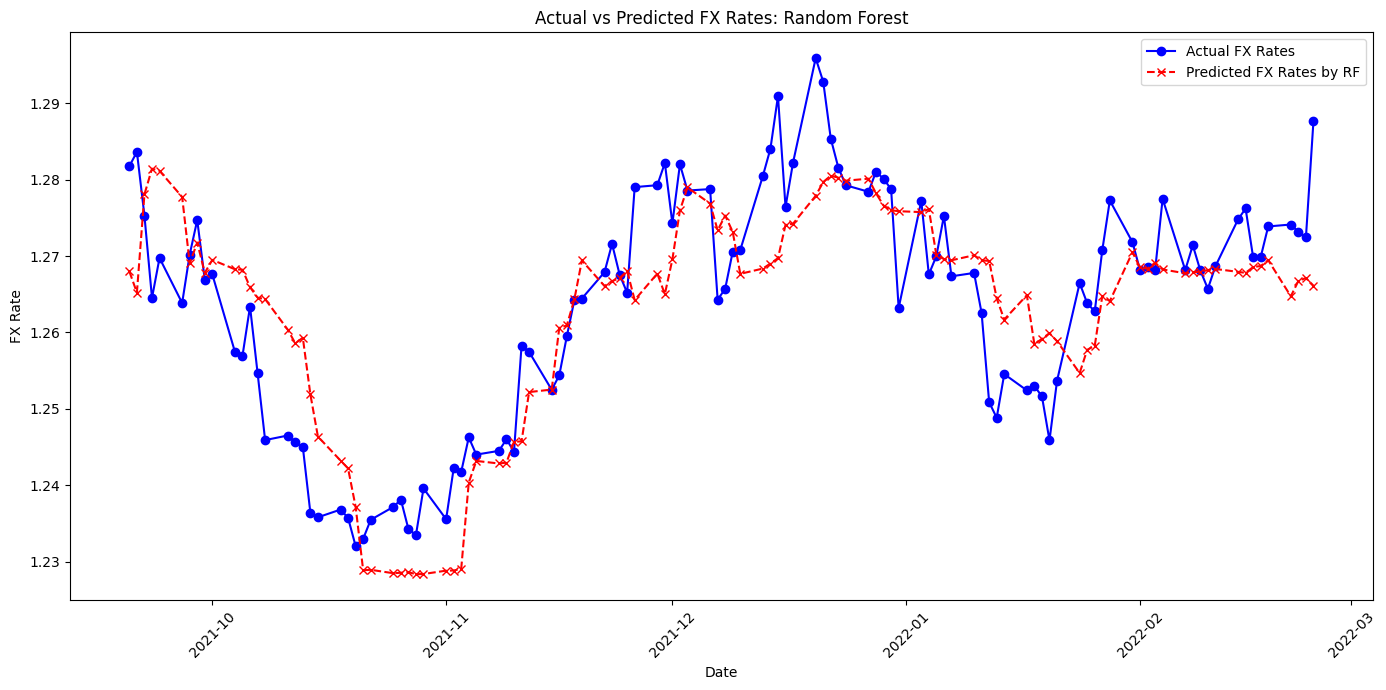

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test, label='Actual FX Rates', color='blue', marker='o')
plt.plot(test_dates, predictions_rf, label='Predicted FX Rates by RF', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted FX Rates: Random Forest')
plt.xlabel('Date')
plt.ylabel('FX Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test,
    'Predicted': predictions_rf
})

# Specify the file path and name
file_path = f"Currency\{selection}_rf_model_predictions.csv"

# Save the DataFrame to a CSV file
results_df.to_csv(file_path, index=False)

print(f'Results saved to {file_path}')


Results saved to Currency\CA_rf_model_predictions.csv


In [28]:
country_test_df = country_test_df.reset_index()

print(country_test_df.columns)

Index(['Date', 'CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE'], dtype='object')


First Model - MAE: 0.0082, RMSE: 0.0098
Second Model - MAE: 0.0070, RMSE: 0.0089


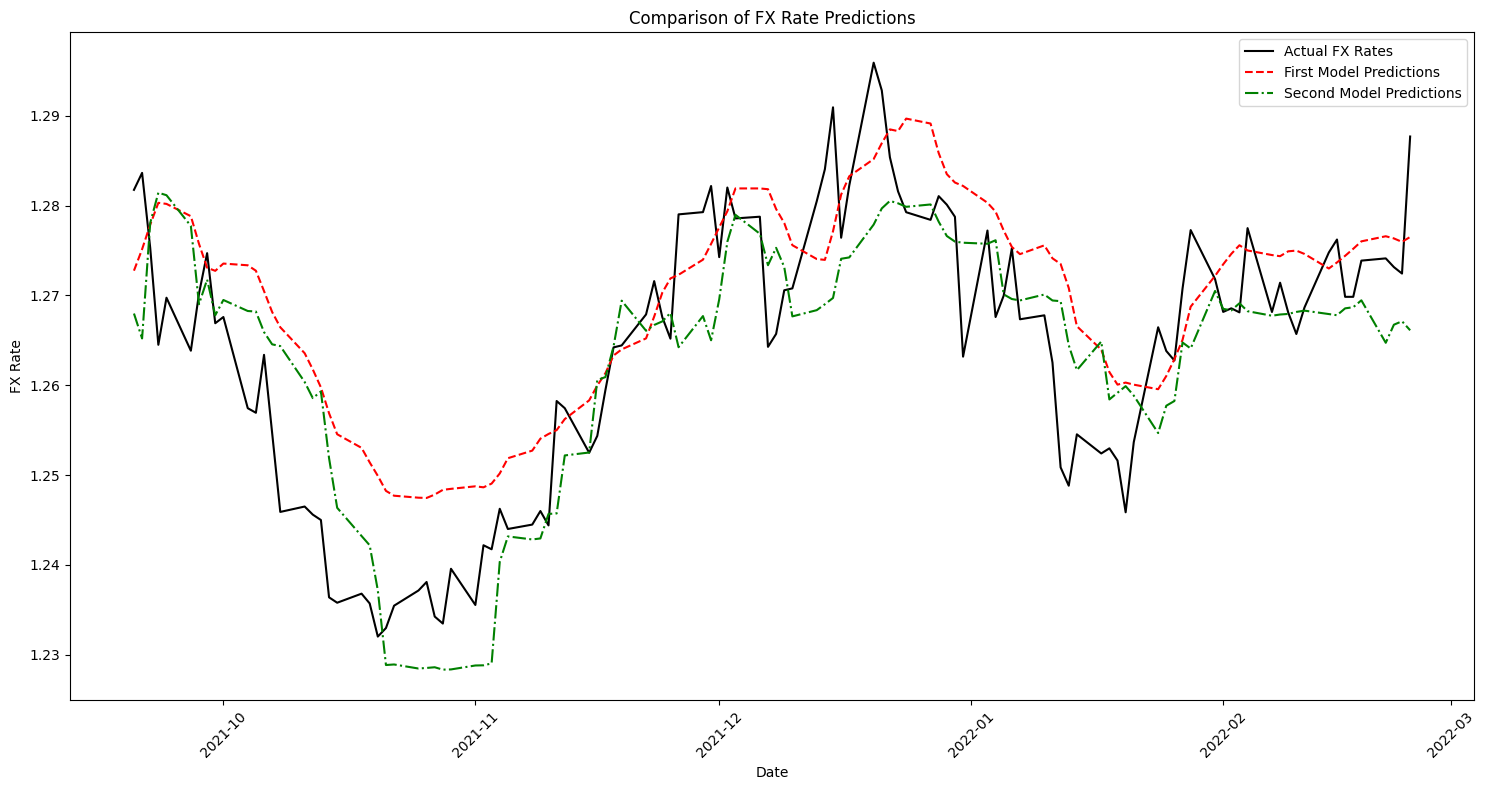

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the predictions from both models
first_model_df = pd.read_excel(f'Currency\{selection}_pred.xlsx', usecols="B:C", header=0)
first_model_df.columns = ['Date', 'Predicted_FX_First_Model']
first_model_df['Date'] = pd.to_datetime(first_model_df['Date'])

second_model_df = pd.read_csv(f"Currency\{selection}_rf_model_predictions.csv")
second_model_df['Date'] = pd.to_datetime(second_model_df['Date'])
second_model_df.rename(columns={'Predicted': 'Predicted_FX_Second_Model'}, inplace=True)

# Convert the 'Date' column in country_test_df to datetime if it's not already
country_test_df['Date'] = pd.to_datetime(country_test_df['Date'])

# Merge the DataFrames on the 'Date' column using 'inner' to avoid NaN values
comparison_df = country_test_df.merge(first_model_df, on='Date', how='inner').merge(second_model_df[['Date', 'Predicted_FX_Second_Model']], on='Date', how='inner')

# Proceed with your analysis and plotting
mae_first = mean_absolute_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_First_Model'])
rmse_first = np.sqrt(mean_squared_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_First_Model']))

mae_second = mean_absolute_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_Second_Model'])
rmse_second = np.sqrt(mean_squared_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_Second_Model']))

print(f'First Model - MAE: {mae_first:.4f}, RMSE: {rmse_first:.4f}')
print(f'Second Model - MAE: {mae_second:.4f}, RMSE: {rmse_second:.4f}')

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(comparison_df['Date'], comparison_df[country_currency_column], label='Actual FX Rates', color='black')
plt.plot(comparison_df['Date'], comparison_df['Predicted_FX_First_Model'], label='First Model Predictions', color='red', linestyle='--')
plt.plot(comparison_df['Date'], comparison_df['Predicted_FX_Second_Model'], label='Second Model Predictions', color='green', linestyle='-.')
plt.title('Comparison of FX Rate Predictions')
plt.xlabel('Date')
plt.ylabel('FX Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
X_test_less_last_4 = X_test.iloc[:, :-4]
X_test_less_last_4

,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,...,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange
448,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,...,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,8566.0
449,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,...,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,3871.0
450,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,...,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,4137.0
451,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,...,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,4572.0
452,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,...,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,4527.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,3.0,3.0,2.0,4.0,1.0,0.0,2.0,2.0,1.0,1.0,...,0.0,2.0,1.0,1.0,0.0,0.0,3.0,5.0,3.0,6747.0
558,2.0,2.0,1.0,4.0,1.0,0.0,2.0,2.0,1.0,1.0,...,0.0,2.0,1.0,1.0,0.0,0.0,3.0,5.0,2.0,3657.0
559,2.0,2.0,1.0,4.0,1.0,0.0,2.0,2.0,1.0,1.0,...,0.0,2.0,1.0,1.0,0.0,0.0,3.0,5.0,2.0,7991.0
560,2.0,2.0,1.0,4.0,1.0,0.0,2.0,2.0,1.0,1.0,...,0.0,2.0,1.0,1.0,0.0,0.0,3.0,5.0,2.0,9812.0


In [31]:
!pip install shap

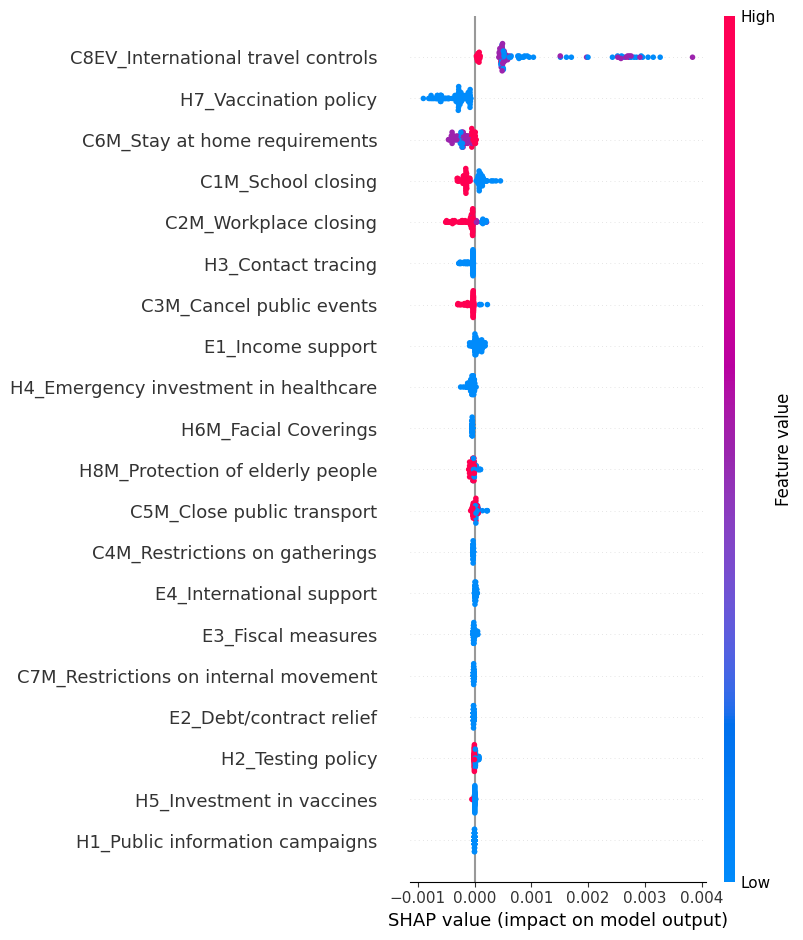

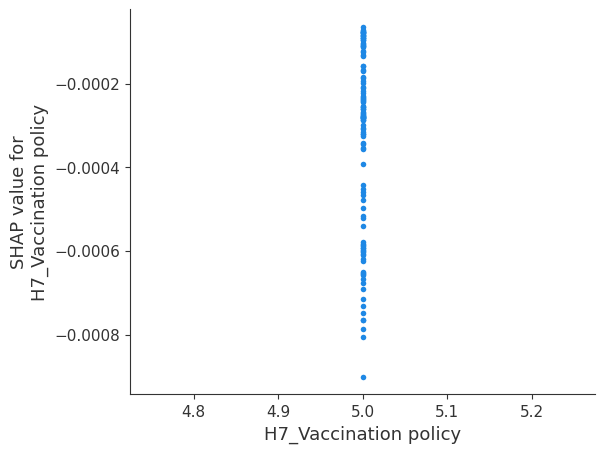

In [32]:
import shap

explainer = shap.TreeExplainer(rf_regressor)

shap_values = explainer.shap_values(X_test)

# List of columns you want to display in the summary plot
display_columns = features_columns[:-5]  # Specify the columns you want to display

# Find the indices of the display columns in the original feature matrix
display_indices = [list(X_test.columns).index(col) for col in display_columns]

# Select the corresponding SHAP values and features for the display columns
shap_values_display = shap_values[:, display_indices]
X_display = X_test.iloc[:, display_indices]

# Generate the summary plot using the selected SHAP values and features
shap.summary_plot(shap_values_display, X_display)

# 1. Force Plot
sample_index = 0  # Choose an index for which you want to generate the force plot
shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test.iloc[sample_index], feature_names=features_columns)

# 2. Dependence Plot
feature_index = X_test.columns.get_loc("H7_Vaccination policy")
shap.dependence_plot(feature_index, shap_values, X_test, feature_names=features_columns, interaction_index=None)

# plt.show()

# shap.summary_plot(shap_values, X_test, feature_names=features_columns)

In [33]:
pd.set_option('display.max_columns', None)

In [34]:
!pip install dice-ml

In [35]:
import dice_ml
from dice_ml.utils import helpers  # helper functions

df_for_dice = pd.concat([X_train, y_train], axis=1)
d = dice_ml.Data(dataframe=df_for_dice, continuous_features=['Predicted_FX','DailyChange'], outcome_name = country_currency_column)
m = dice_ml.Model(model=rf_regressor, backend='sklearn', model_type='regressor')
dice = dice_ml.Dice(d,m)

# Generate counterfactual examples
dice_exp = dice.generate_counterfactuals(X_test.head(), total_CFs=3, desired_range=[0.0,2.0], features_to_vary=features_columns[:-5])

# Visualize the results
dice_exp.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

Query instance (original outcome : 1.0)


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,8566.0,2021,9,20,1.272762,1.0



Diverse Counterfactual set (new outcome: [0.0, 2.0])


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,1.2679890394210815
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.2679890394210815
2,-,-,-,-,-,-,-,-,-,-,-,8020490.0,-,-,-,-,-,0.0,-,-,-,-,-,-,-,1.2679890394210815


Query instance (original outcome : 1.0)


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,3871.0,2021,9,21,1.275147,1.0



Diverse Counterfactual set (new outcome: [0.0, 2.0])


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,-,-,-,-,-,-,-,-,-,-,50000000.0,-,-,-,2.0,-,-,-,-,-,-,-,-,-,-,1.2652136087417603
1,-,-,-,-,-,-,-,-,-,-,-,8020490.0,-,-,-,-,-,-,-,-,-,-,-,-,-,1.2652136087417603
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0,-,-,-,-,-,-,-,-,-,-,1.2652136087417603


Query instance (original outcome : 1.0)


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,4137.0,2021,9,22,1.277886,1.0



Diverse Counterfactual set (new outcome: [0.0, 2.0])


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,1.277921438217163
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,3.0,-,-,-,-,-,-,1.2784302234649658
2,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,1829738.25,-,-,-,-,-,-,-,-,1.2780817747116089


Query instance (original outcome : 1.0)


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,4572.0,2021,9,23,1.280316,1.0



Diverse Counterfactual set (new outcome: [0.0, 2.0])


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.2814428806304932
1,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.2814428806304932
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0,10923164.0,-,-,-,-,-,-,-,-,-,1.2818729877471924


Query instance (original outcome : 1.0)


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,3.0,3.0,2.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,5.0,3.0,4527.0,2021,9,24,1.280197,1.0



Diverse Counterfactual set (new outcome: [0.0, 2.0])


,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,DailyChange,Year,Month,Day,Predicted_FX,CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
0,-,2.0,-,-,-,-,-,-,-,-,-,-,-,-,-,558198900.0,-,-,-,-,-,-,-,-,-,1.2816044092178345
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0,-,-,-,-,-,-,-,-,-,-,1.2811638116836548
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0,-,-,-,-,-,-,1.2822844982147217


In [36]:
comparison_df['Predicted_FX_Second_Model'].head()

0    1.267989
1    1.265214
2    1.278082
3    1.281443
4    1.281164
Name: Predicted_FX_Second_Model, dtype: float64

In [37]:
feature_ranges = pd.DataFrame(columns=['Feature', 'Min', 'Max'])

# Loop through each feature and calculate its minimum and maximum values
for feature in df_for_dice.columns:
    feature_min = df_for_dice[feature].min()
    feature_max = df_for_dice[feature].max()
    feature_ranges = feature_ranges.append({'Feature': feature, 'Min': feature_min, 'Max': feature_max}, ignore_index=True)

print(feature_ranges)

                                            Feature          Min           Max
0                                C1M_School closing     0.000000  3.000000e+00
1                             C2M_Workplace closing     0.000000  3.000000e+00
2                          C3M_Cancel public events     0.000000  2.000000e+00
3                    C4M_Restrictions on gatherings     0.000000  4.000000e+00
4                        C5M_Close public transport     0.000000  1.000000e+00
5                     C6M_Stay at home requirements     0.000000  2.000000e+00
6             C7M_Restrictions on internal movement     0.000000  2.000000e+00
7                C8EV_International travel controls     0.000000  4.000000e+00
8                                 E1_Income support     0.000000  2.000000e+00
9                           E2_Debt/contract relief     0.000000  1.000000e+00
10                               E3_Fiscal measures     0.000000  7.519973e+10
11                         E4_International support 

<ipython-input-37-1a464a29d755>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_ranges = feature_ranges.append({'Feature': feature, 'Min': feature_min, 'Max': feature_max}, ignore_index=True)
<ipython-input-37-1a464a29d755>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_ranges = feature_ranges.append({'Feature': feature, 'Min': feature_min, 'Max': feature_max}, ignore_index=True)
<ipython-input-37-1a464a29d755>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_ranges = feature_ranges.append({'Feature': feature, 'Min': feature_min, 'Max': feature_max}, ignore_index=True)
<ipython-input-37-1a464a29d755>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur